In [3]:
# First check if your dataset path is correct
import os
import numpy as np
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


root_dir = '.' 
print("Checking dataset structure...")

# Verify training folders exist
train_image_dir = os.path.join(root_dir, 'data/data_object_image_2/training', 'image_2')
train_label_dir = os.path.join(root_dir, 'data/data_object_label_2/training', 'label_2')
train_calib_dir = os.path.join(root_dir, 'data/data_object_calib/training', 'calib')

# Count files in each directory
if os.path.exists(train_image_dir):
    print(f"Number of training images: {len(os.listdir(train_image_dir))}")
if os.path.exists(train_label_dir):
    print(f"Number of training labels: {len(os.listdir(train_label_dir))}")
if os.path.exists(train_calib_dir):
    print(f"Number of training calib files: {len(os.listdir(train_calib_dir))}")

Checking dataset structure...
Number of training images: 7481
Number of training labels: 7481
Number of training calib files: 7481


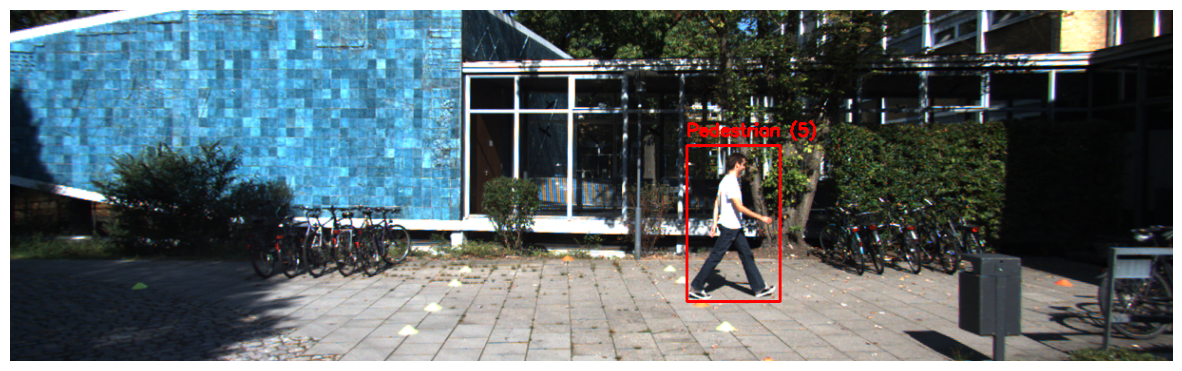

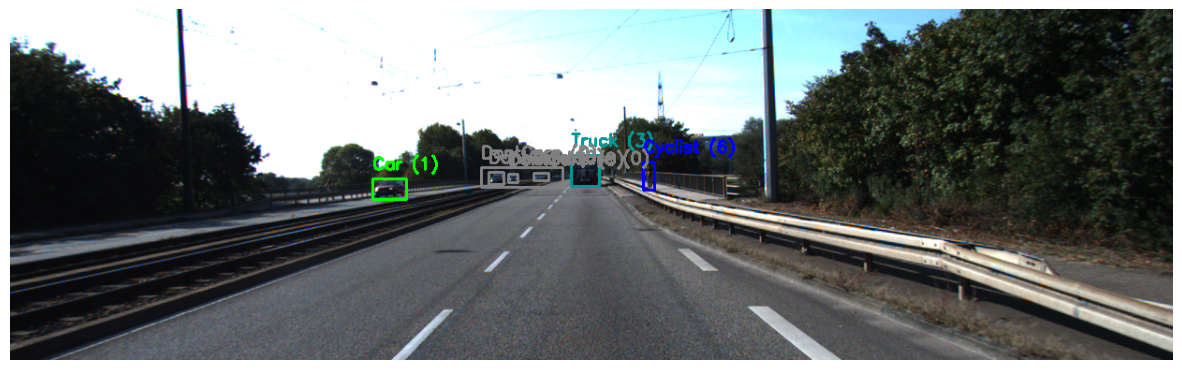

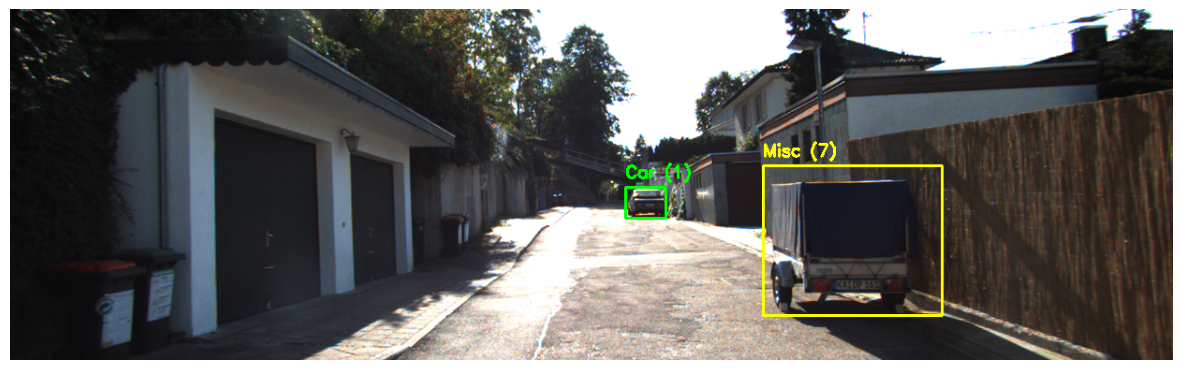

Batch image shape: torch.Size([4, 3, 375, 1242])
Sample 0 has 4 objects
Sample 1 has 6 objects
Sample 2 has 10 objects
Sample 3 has 8 objects


In [36]:
import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, Optional, List, Any

# Move the dataset class definitions to the top level
# This is important for multiprocessing to work correctly

class KittiDataset(Dataset):
    """PyTorch Dataset class for KITTI with multi-class support"""
    
    def __init__(self, processor, transform=None):
        self.processor = processor
        self.transform = transform or self.default_transform()
        self.class_mapping = processor.get_class_mapping()
        
    @staticmethod
    def default_transform():
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((375, 1242)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.processor.image_files)
    
    def __getitem__(self, idx):
        image, bboxes, class_labels, _ = self.processor.load_data(idx)
        
        if image is None:
            image = torch.zeros((3, 375, 1242), dtype=torch.float32)
            return image, {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx])
            }
            
        if self.transform:
            image = self.transform(image)
            
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32) if len(bboxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor([self.class_mapping[cls] for cls in class_labels], 
                            dtype=torch.int64) if len(class_labels) > 0 else torch.zeros((0,), dtype=torch.int64)
        
        return image, {
            'boxes': bboxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return torch.stack(images, 0), targets

class KittiDatasetProcessor:
    """Complete KITTI dataset processor"""
    def __init__(self, root_dir='.'):
        self.root_dir = Path(root_dir).absolute()
        self._setup_paths()
        self._verify_dataset()
        self._precompute_file_lists()
        
    def _setup_paths(self):
        possible_paths = [
            self.root_dir / 'data_object_image_2' / 'training' / 'image_2',
            self.root_dir / 'training' / 'image_2',
            self.root_dir / 'image_2',
            self.root_dir / 'data' / 'object' / 'training' / 'image_2'
        ]
        for path in possible_paths:
            if path.exists():
                self.train_image_dir = path
                break
        else:
            self.train_image_dir = possible_paths[0]
        
        base_dir = self.train_image_dir.parent.parent
        self.train_label_dir = base_dir / 'label_2' if (base_dir / 'label_2').exists() else base_dir.parent / 'data_object_label_2' / 'training' / 'label_2'
        self.train_calib_dir = base_dir / 'calib' if (base_dir / 'calib').exists() else base_dir.parent / 'data_object_calib' / 'training' / 'calib'
        
    def _precompute_file_lists(self):
        self.image_files = sorted(os.listdir(self.train_image_dir))
        self.label_files = sorted(os.listdir(self.train_label_dir))
        self.calib_files = sorted(os.listdir(self.train_calib_dir))
        
    def _verify_dataset(self):
        if not self.train_image_dir.exists():
            raise FileNotFoundError(f"Image directory not found: {self.train_image_dir}")
        if not self.train_label_dir.exists():
            raise FileNotFoundError(f"Label directory not found: {self.train_label_dir}")
        if not self.train_calib_dir.exists():
            raise FileNotFoundError(f"Calibration directory not found: {self.train_calib_dir}")
            
    @staticmethod
    def get_class_mapping():
        return {
            'DontCare': 0, 'Car': 1, 'Van': 2, 'Truck': 3,
            'Tram': 4, 'Pedestrian': 5, 'Cyclist': 6, 'Misc': 7
        }
    
    @staticmethod
    def get_class_colors():
        return {
            0: (128, 128, 128), 1: (0, 255, 0),
            2: (0, 200, 100), 3: (0, 150, 150),
            4: (0, 100, 200), 5: (255, 0, 0),
            6: (0, 0, 255), 7: (255, 255, 0)
        }
        
    def parse_label(self, filename):
        column_names = [
            'type', 'truncated', 'occluded', 'alpha',
            'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
            'dim_height', 'dim_width', 'dim_length',
            'loc_x', 'loc_y', 'loc_z', 'rotation_y'
        ]
        try:
            df = pd.read_csv(filename, sep=' ', header=None, names=column_names)
            valid_classes = list(self.get_class_mapping().keys())
            valid_objects = df[df['type'].isin(valid_classes)]
            return valid_objects[(valid_objects['bbox_right'] > valid_objects['bbox_left']) & 
                               (valid_objects['bbox_bottom'] > valid_objects['bbox_top'])]
        except Exception as e:
            print(f"Error parsing label file {filename}: {str(e)}")
            return pd.DataFrame(columns=column_names)
    
    def load_data(self, index):
        try:
            image_name = self.image_files[index]
            base_name = os.path.splitext(image_name)[0]
            
            img_path = self.train_image_dir / image_name
            image = cv2.imread(str(img_path))
            if image is None:
                raise ValueError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            label_path = self.train_label_dir / f"{base_name}.txt"
            labels = self.parse_label(str(label_path))
            
            bboxes = labels[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values
            class_labels = labels['type'].values if not labels.empty else np.array([])
            
            return image, bboxes, class_labels, {}
            
        except Exception as e:
            print(f"Error loading data for index {index}: {str(e)}")
            return None, np.zeros((0, 4)), np.array([]), {}

    def visualize_sample(self, index, show=True):
        image, bboxes, class_labels, _ = self.load_data(index)
        if image is None:
            return None
            
        vis_image = image.copy()
        class_colors = self.get_class_colors()
        class_mapping = self.get_class_mapping()
        
        for bbox, cls in zip(bboxes, class_labels):
            x1, y1, x2, y2 = map(int, bbox)
            class_id = class_mapping[cls]
            color = class_colors[class_id]
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_image, f"{cls} ({class_id})", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        if show:
            plt.figure(figsize=(15, 8))
            plt.imshow(vis_image)
            plt.axis('off')
            plt.show()
        
        return vis_image

def main():
    # Initialize processor - modify this path as needed
    processor = KittiDatasetProcessor(root_dir='data')
    
    # Visualize samples
    for i in range(3):
        processor.visualize_sample(i)
    
    # Create dataset with num_workers=0 to avoid multiprocessing issues
    dataset = KittiDataset(processor)
    dataloader = DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0  # Disable multiprocessing to avoid pickling issues
    )
    
    # Test the dataloader
    for images, targets in dataloader:
        print(f"Batch image shape: {images.shape}")
        for i, target in enumerate(targets):
            print(f"Sample {i} has {len(target['labels'])} objects")
        break

if __name__ == "__main__":
    # Add this to ensure proper multiprocessing behavior
    torch.multiprocessing.set_start_method('spawn', force=True)
    main()

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import torch
import torchvision.transforms as transforms

# 🔹 Define dataset paths
root_dir = 'data'  # Change this if your dataset is in a different location
image_dir = os.path.join(root_dir, 'data_object_image_2/training/image_2')
label_dir = os.path.join(root_dir, 'data_object_label_2/training/label_2')
calib_dir = os.path.join(root_dir, 'data_object_calib/training/calib')

# 🔹 Check if paths exist
if not all(os.path.exists(d) for d in [image_dir, label_dir, calib_dir]):
    raise FileNotFoundError("One or more dataset directories not found!")

# 🔹 List all image files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# 🔹 Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((375, 1242)),  # Resize to KITTI resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 🔹 Function to read label files
def parse_label(label_path):
    column_names = ['type', 'truncated', 'occluded', 'alpha', 
                    'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
                    'dim_height', 'dim_width', 'dim_length', 
                    'loc_x', 'loc_y', 'loc_z', 'rotation_y']
    
    df = pd.read_csv(label_path, sep=' ', header=None, names=column_names)
    df = df[df['type'].isin(['Car', 'Van', 'Truck'])]  # Keep only vehicle classes
    return df[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values  # Return bounding boxes

# 🔹 Function to load an image and its labels
def parse_label(label_path):
    column_names = ['type', 'truncated', 'occluded', 'alpha', 
                    'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
                    'dim_height', 'dim_width', 'dim_length', 
                    'loc_x', 'loc_y', 'loc_z', 'rotation_y']
    
    try:
        df = pd.read_csv(label_path, sep=' ', header=None, names=column_names)

        # 🔹 Keep only vehicles and pedestrians
        df = df[df['type'].isin(['Car', 'Van', 'Truck', 'Pedestrian'])]  

        # 🔹 Extract bounding box values
        bboxes = df[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values

        if bboxes.size == 0:
            print(f"⚠ Warning: No valid objects found in {label_path}")

        return bboxes

    except Exception as e:
        print(f"Error reading {label_path}: {e}")
        return np.zeros((0, 4))  # Return empty array if error

    except Exception as e:
        print(f"❌ Error reading {label_path}: {e}")
        return np.zeros((0, 4))  
# 🔹 Test loading function
index = 0  # Change this to test different images
img_tensor, bbox_array = load_data(index)

print(f"\n✅ Loaded Image Shape: {img_tensor.shape}")  # Should be (3, 375, 1242)
print(f"✅ Bounding Boxes: {bbox_array}")


✅ Loaded Image Shape: torch.Size([3, 375, 1242])
✅ Bounding Boxes: [[712.4  143.   810.73 307.92]]


Checking dataset structure...
Number of training images: 7481
Number of training labels: 7481
Number of training calib files: 7481


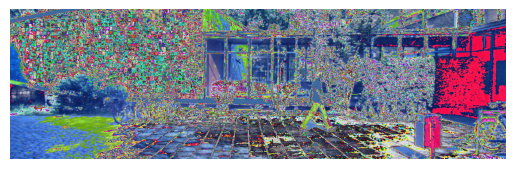

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Expected Ptr<cv::UMat> for argument 'img'


In [17]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

# Define paths to your KITTI dataset
root_dir = '.'  # Update to the correct path of your dataset
train_image_dir = os.path.join(root_dir, 'data/data_object_image_2/training', 'image_2')
train_label_dir = os.path.join(root_dir, 'data/data_object_label_2/training', 'label_2')
train_calib_dir = os.path.join(root_dir, 'data/data_object_calib/training', 'calib')

# Checking the dataset structure
print("Checking dataset structure...")
if os.path.exists(train_image_dir):
    print(f"Number of training images: {len(os.listdir(train_image_dir))}")
if os.path.exists(train_label_dir):
    print(f"Number of training labels: {len(os.listdir(train_label_dir))}")
if os.path.exists(train_calib_dir):
    print(f"Number of training calib files: {len(os.listdir(train_calib_dir))}")

# Function to load and parse the calibration files
def parse_calibration(filename):
    calib = {}
    with open(filename, 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.split(':', 1)
                calib[key.strip()] = np.array([float(x) for x in value.strip().split()])
    return calib

# Function to load and parse label files
def parse_label(filename):
    column_names = ['type', 'truncated', 'occluded', 'alpha', 
                    'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
                    'dim_height', 'dim_width', 'dim_length', 
                    'loc_x', 'loc_y', 'loc_z', 'rotation_y']
    try:
        df = pd.read_csv(filename, sep=' ', header=None, names=column_names)
        return df[df['type'].isin(['Car', 'Van', 'Truck'])]  # Filter vehicles
    except:
        return pd.DataFrame(columns=column_names)

# Function to load a single image, its label and calibration
def load_data(index, image_dir, label_dir, calib_dir):
    image_name = sorted(os.listdir(image_dir))[index]  # Get the image filename by index
    base_name = os.path.splitext(image_name)[0]
    
    # Load image
    img_path = os.path.join(image_dir, image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Load calibration
    calib_path = os.path.join(calib_dir, f"{base_name}.txt")
    calib = parse_calibration(calib_path)
    
    # Load label
    label_path = os.path.join(label_dir, f"{base_name}.txt")
    labels = parse_label(label_path)
    
    bboxes = labels[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values if not labels.empty else np.zeros((0, 4))  # No labels for testing
    
    return image, bboxes

# Function to visualize the image with bounding boxes
def visualize_image_with_bboxes(image, bboxes):
    # Convert tensor to numpy array (from PyTorch tensor)
    image = image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    image = np.array(image * 255, dtype=np.uint8)  # Scale the image from [0, 1] to [0, 255]
    
    # Draw bounding boxes
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Transform to resize and normalize the image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((375, 1242)),  # KITTI image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loop through all the images in the dataset
num_images = len(os.listdir(train_image_dir))
for index in range(num_images):
    image, bboxes = load_data(index, train_image_dir, train_label_dir, train_calib_dir)
    image_transformed = transform(image)  # Apply transformations to the image

    # Visualize the image with its bounding boxes
    visualize_image_with_bboxes(image_transformed, bboxes)

In [8]:
import matplotlib.pyplot as plt

def visualize_image_with_bboxes(image, bboxes):
    # Convert tensor to numpy array (if using PyTorch tensor)
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # Draw bounding boxes
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize the first image with its bounding box
visualize_image_with_bboxes(train_batch['images'][0], train_batch['bboxes'][0])

NameError: name 'train_batch' is not defined

Verifying dataset structure...
Found 7481 images, 7481 labels, 7481 calibration files


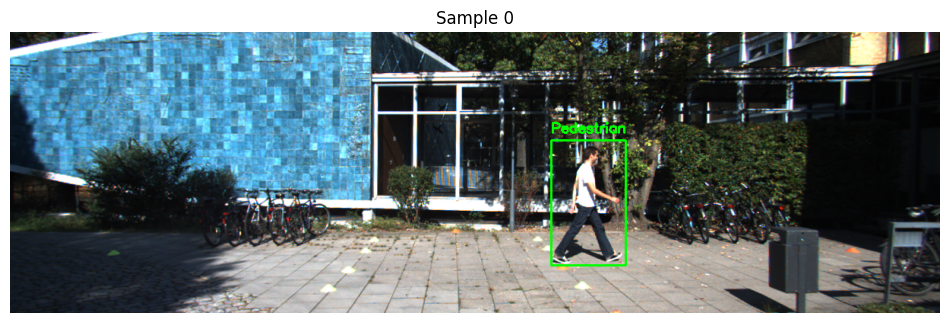

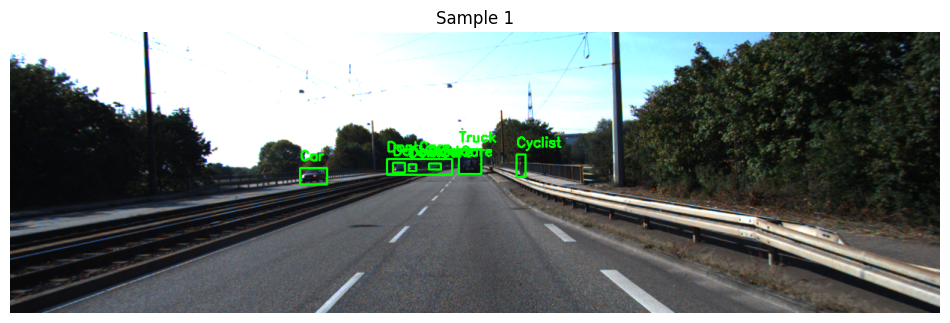

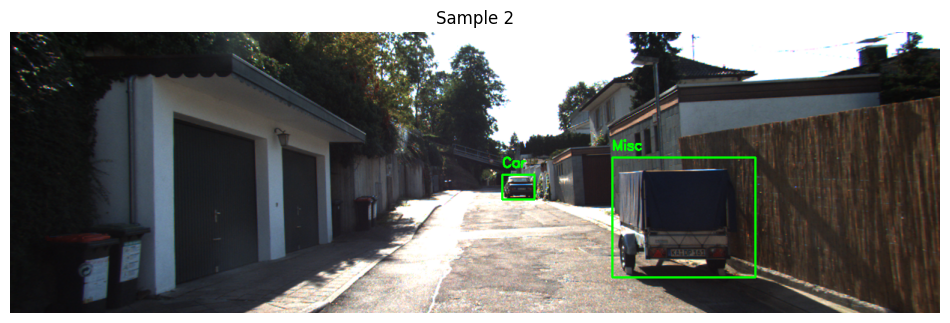

Batch image shape: torch.Size([4, 3, 375, 1242])
Number of targets in batch: 4
  Sample 0: 6 objects
  Sample 1: 8 objects
  Sample 2: 12 objects
  Sample 3: 10 objects


In [21]:
import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, Optional, List

class KittiDatasetProcessor:
    """Enhanced KITTI dataset processor with improved functionality"""
    
    def __init__(self, root_dir: str = '.'):
        self.root_dir = Path(root_dir)
        self._setup_paths()
        self._verify_dataset()
        self._precompute_file_lists()
        
    def _setup_paths(self):
        """Initialize all dataset paths"""
        self.train_image_dir = self.root_dir / 'data/data_object_image_2/training/image_2'
        self.train_label_dir = self.root_dir / 'data/data_object_label_2/training/label_2'
        self.train_calib_dir = self.root_dir / 'data/data_object_calib/training/calib'
        
    def _verify_dataset(self):
        """Verify dataset structure and file counts"""
        print("Verifying dataset structure...")
        assert self.train_image_dir.exists(), f"Image directory not found: {self.train_image_dir}"
        assert self.train_label_dir.exists(), f"Label directory not found: {self.train_label_dir}"
        assert self.train_calib_dir.exists(), f"Calibration directory not found: {self.train_calib_dir}"
        
        self.num_images = len(os.listdir(self.train_image_dir))
        self.num_labels = len(os.listdir(self.train_label_dir))
        self.num_calib = len(os.listdir(self.train_calib_dir))
        
        print(f"Found {self.num_images} images, {self.num_labels} labels, {self.num_calib} calibration files")
        assert self.num_images == self.num_labels == self.num_calib, "Mismatch in file counts"
        
    def _precompute_file_lists(self):
        """Precompute sorted file lists for faster access"""
        self.image_files = sorted(os.listdir(self.train_image_dir))
        self.label_files = sorted(os.listdir(self.train_label_dir))
        self.calib_files = sorted(os.listdir(self.train_calib_dir))
        
    def parse_calibration(self, filename: str) -> Dict[str, np.ndarray]:
        """Parse calibration file into dictionary"""
        calib = {}
        try:
            with open(filename, 'r') as f:
                for line in f:
                    if ':' in line:
                        key, value = line.split(':', 1)
                        calib[key.strip()] = np.array([float(x) for x in value.strip().split()])
        except Exception as e:
            print(f"Error parsing calibration file {filename}: {str(e)}")
            return {}
        return calib
    
    def parse_label(self, filename: str) -> pd.DataFrame:
        """Parse label file into DataFrame with enhanced filtering"""
        column_names = [
            'type', 'truncated', 'occluded', 'alpha',
            'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
            'dim_height', 'dim_width', 'dim_length',
            'loc_x', 'loc_y', 'loc_z', 'rotation_y'
        ]
        
        try:
            df = pd.read_csv(filename, sep=' ', header=None, names=column_names)
            # Filter for vehicles and valid bounding boxes
            vehicle_types = ['Car', 'Van', 'Truck', 'Tram','Pedestrian','DontCare','Cyclist','Misc']
            valid_vehicles = df[df['type'].isin(vehicle_types)]
            return valid_vehicles[(valid_vehicles['bbox_right'] > valid_vehicles['bbox_left']) & 
                                 (valid_vehicles['bbox_bottom'] > valid_vehicles['bbox_top'])]
        except Exception as e:
            print(f"Error parsing label file {filename}: {str(e)}")
            return pd.DataFrame(columns=column_names)
    
    def load_data(self, index: int) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """Load image, bounding boxes, and calibration data"""
        try:
            image_name = self.image_files[index]
            base_name = os.path.splitext(image_name)[0]
            
            # Load image
            img_path = self.train_image_dir / image_name
            image = cv2.imread(str(img_path))
            if image is None:
                raise ValueError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load calibration
            calib_path = self.train_calib_dir / f"{base_name}.txt"
            calib = self.parse_calibration(str(calib_path))
            
            # Load labels
            label_path = self.train_label_dir / f"{base_name}.txt"
            labels = self.parse_label(str(label_path))
            
            bboxes = labels[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values
            class_labels = labels['type'].values if not labels.empty else np.array([])
            
            return image, bboxes, class_labels, calib
            
        except Exception as e:
            print(f"Error loading data for index {index}: {str(e)}")
            return None, None, None, None
    
    def visualize_sample(self, index: int, show: bool = True) -> Optional[np.ndarray]:
        """Visualize a sample with bounding boxes and class labels"""
        image, bboxes, class_labels, _ = self.load_data(index)
        if image is None:
            return None
            
        # Draw bounding boxes and labels
        for i, (bbox, cls) in enumerate(zip(bboxes, class_labels)):
            x1, y1, x2, y2 = map(int, bbox)
            color = (0, 255, 0)  # Green for vehicles
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, cls, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        if show:
            plt.figure(figsize=(12, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Sample {index}")
            plt.show()
        
        return image
class KittiDataset(Dataset):
    """PyTorch Dataset class for KITTI with proper transformations"""
    
    def __init__(self, processor: KittiDatasetProcessor, transform=None):
        self.processor = processor
        self.transform = transform or self.default_transform()
        
    @staticmethod
    def default_transform():
        """Default transforms for KITTI images"""
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((375, 1242)),  # Maintain KITTI aspect ratio
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.processor.image_files)
    
    def __getitem__(self, idx):
        image, bboxes, class_labels, calib = self.processor.load_data(idx)
        if image is None:
            # Return empty data if loading failed
            image = torch.zeros((3, 375, 1242), dtype=torch.float32)
            return image, {'boxes': torch.zeros((0, 4), dtype=torch.float32), 
                         'labels': torch.zeros((0,), dtype=torch.int64)}
            
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        # Convert bboxes to tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32) if len(bboxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        
        # Simple label encoding (1 for vehicle, 0 for background)
        labels = torch.ones((len(bboxes),), dtype=torch.int64) if len(bboxes) > 0 else torch.zeros((0,), dtype=torch.int64)
        
        return image, {'boxes': bboxes, 'labels': labels}

def collate_fn(batch):
    """Custom collate function to handle variable numbers of objects"""
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        targets.append(target)
        
    # Stack images
    images = torch.stack(images, dim=0)
    
    return images, targets

# Example usage
if __name__ == "__main__":
    # Initialize processor
    processor = KittiDatasetProcessor(root_dir='.')
    
    # Visualize first 3 samples
    for i in range(3):
        processor.visualize_sample(i)
    
    # Create PyTorch dataset and dataloader with custom collate function
    dataset = KittiDataset(processor)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    
    # Example training loop
    for images, targets in dataloader:
        print(f"Batch image shape: {images.shape}")
        print(f"Number of targets in batch: {len(targets)}")
        for i, target in enumerate(targets):
            print(f"  Sample {i}: {len(target['boxes'])} objects")
        break  # Just show first batch for demonstration

In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import FastRCNNPredictor

# Example Model: Using a pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier to match the number of classes (1 for vehicles)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # 2 classes: 1 vehicle + 0 background

# Optimizer and Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Example Training Loop
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, targets in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Backpropagation
            losses.backward()
            optimizer.step()
            
            running_loss += losses.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Training
train_model(model, dataloader, optimizer)

ImportError: cannot import name 'FastRCNNPredictor' from 'torchvision.models.detection' (/Users/darshanjethva/Library/Python/3.9/lib/python/site-packages/torchvision/models/detection/__init__.py)


Trying root directory: .
Initializing KITTI processor with root directory: /Users/darshanjethva/Desktop/BTECH_AI/atml_project/ATML_PROJECT

Verifying dataset structure...
Looking for images in: /Users/darshanjethva/Desktop/BTECH_AI/atml_project/ATML_PROJECT/data_object_image_2/training/image_2
Looking for labels in: /Users/darshanjethva/Desktop/BTECH_AI/atml_project/ATML_PROJECT/data_object_label_2/training/label_2
Looking for calib in: /Users/darshanjethva/Desktop/BTECH_AI/atml_project/ATML_PROJECT/data_object_calib/training/calib
Not found in .: Image directory not found at: /Users/darshanjethva/Desktop/BTECH_AI/atml_project/ATML_PROJECT/data_object_image_2/training/image_2
Please ensure:
1. You have downloaded the KITTI object detection dataset
2. The dataset is in the correct directory structure
3. You have set the correct root directory
Typical structure:
  - data_object_image_2/training/image_2
  - data_object_label_2/training/label_2
  - data_object_calib/training/calib

Trying

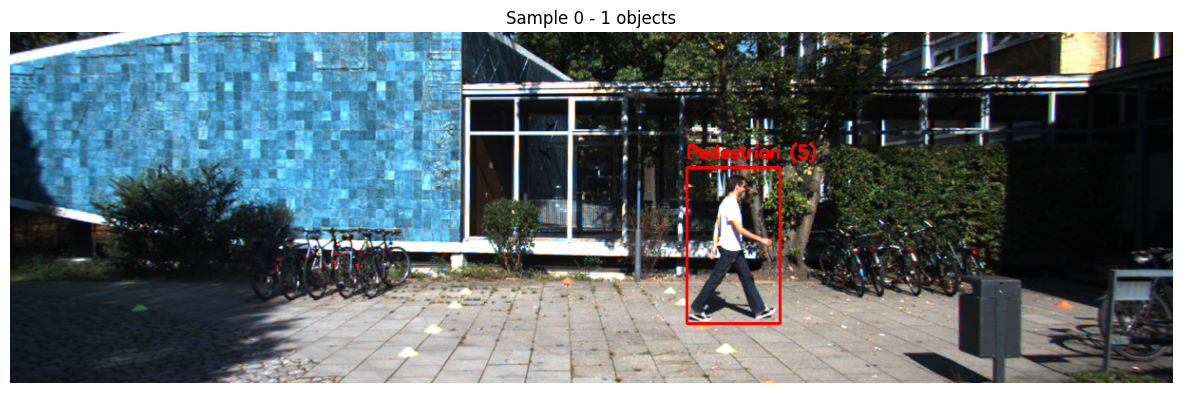

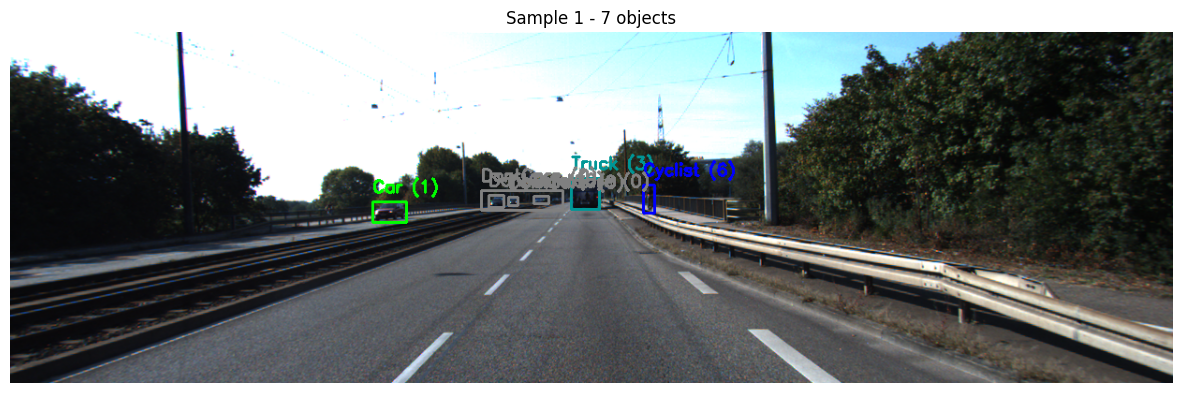

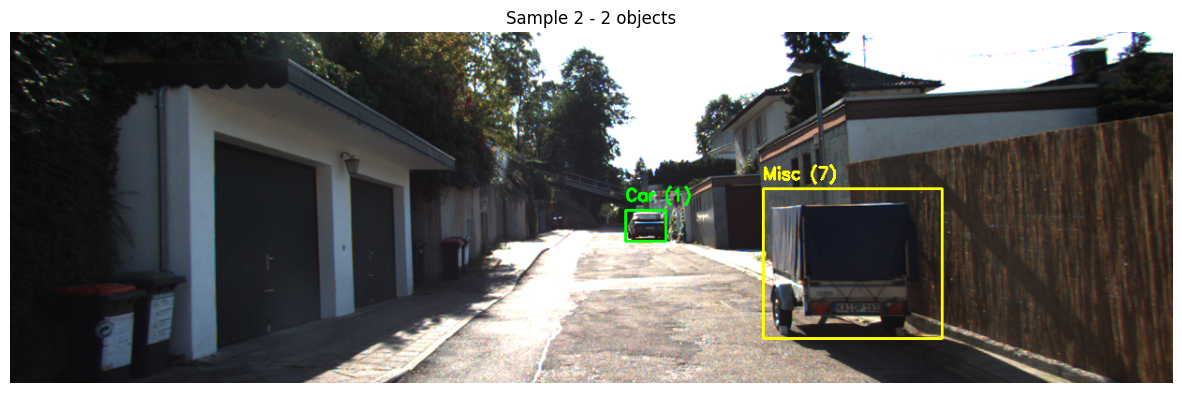


Testing dataloader...


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'KittiDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [34]:
import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, Optional, List, Any

class KittiDatasetProcessor:
    """Complete KITTI dataset processor with multi-class support"""
    
    def __init__(self, root_dir: str = '.'):
        self.root_dir = Path(root_dir).absolute()  # Convert to absolute path
        print(f"Initializing KITTI processor with root directory: {self.root_dir}")
        self._setup_paths()
        self._verify_dataset()
        self._precompute_file_lists()  # This method is now properly defined
        
    def _setup_paths(self):
        """Initialize all dataset paths with more flexible structure"""
        # Try multiple possible directory structures
        possible_paths = [
            self.root_dir / 'data_object_image_2' / 'training' / 'image_2',
            self.root_dir / 'training' / 'image_2',
            self.root_dir / 'image_2',
            self.root_dir / 'data' / 'object' / 'training' / 'image_2'
        ]
        
        # Find the first existing image directory
        for path in possible_paths:
            if path.exists():
                self.train_image_dir = path
                break
        else:
            self.train_image_dir = possible_paths[0]  # Will raise error later
        
        # Similarly for labels and calibration
        base_dir = self.train_image_dir.parent.parent
        self.train_label_dir = base_dir / 'label_2' if (base_dir / 'label_2').exists() else base_dir.parent / 'data_object_label_2' / 'training' / 'label_2'
        self.train_calib_dir = base_dir / 'calib' if (base_dir / 'calib').exists() else base_dir.parent / 'data_object_calib' / 'training' / 'calib'
        
    def _precompute_file_lists(self):
        """Precompute sorted file lists for faster access"""
        self.image_files = sorted(os.listdir(self.train_image_dir))
        self.label_files = sorted(os.listdir(self.train_label_dir))
        self.calib_files = sorted(os.listdir(self.train_calib_dir))
        print(f"\nPrecomputed file lists with {len(self.image_files)} images")
        
    def _verify_dataset(self):
        """Verify dataset structure with more helpful error messages"""
        print("\nVerifying dataset structure...")
        print(f"Looking for images in: {self.train_image_dir}")
        print(f"Looking for labels in: {self.train_label_dir}")
        print(f"Looking for calib in: {self.train_calib_dir}")
        
        if not self.train_image_dir.exists():
            raise FileNotFoundError(
                f"Image directory not found at: {self.train_image_dir}\n"
                "Please ensure:\n"
                "1. You have downloaded the KITTI object detection dataset\n"
                "2. The dataset is in the correct directory structure\n"
                "3. You have set the correct root directory\n"
                "Typical structure:\n"
                "  - data_object_image_2/training/image_2\n"
                "  - data_object_label_2/training/label_2\n"
                "  - data_object_calib/training/calib"
            )
        
        if not self.train_label_dir.exists():
            raise FileNotFoundError(f"Label directory not found: {self.train_label_dir}")
        if not self.train_calib_dir.exists():
            raise FileNotFoundError(f"Calibration directory not found: {self.train_calib_dir}")
        
        self.num_images = len(os.listdir(self.train_image_dir))
        self.num_labels = len(os.listdir(self.train_label_dir))
        self.num_calib = len(os.listdir(self.train_calib_dir))
        
        print(f"\nFound:\n"
              f"- {self.num_images} images\n"
              f"- {self.num_labels} label files\n"
              f"- {self.num_calib} calibration files")
        
        if not (self.num_images == self.num_labels == self.num_calib):
            print("\nWarning: Mismatch in file counts! Some samples may be missing corresponding files.")

    @staticmethod
    def get_class_mapping() -> Dict[str, int]:
        """Return the mapping from class names to IDs"""
        return {
            'DontCare': 0,
            'Car': 1,
            'Van': 2,
            'Truck': 3,
            'Tram': 4,
            'Pedestrian': 5,
            'Cyclist': 6,
            'Misc': 7
        }
    
    @staticmethod
    def get_class_names() -> Dict[int, str]:
        """Return the mapping from class IDs to names"""
        return {v: k for k, v in KittiDatasetProcessor.get_class_mapping().items()}
    
    @staticmethod
    def get_class_colors() -> Dict[int, Tuple[int, int, int]]:
        """Return colors for visualization by class ID"""
        return {
            0: (128, 128, 128),  # Gray - DontCare
            1: (0, 255, 0),      # Green - Car
            2: (0, 200, 100),    # Teal - Van
            3: (0, 150, 150),    # Dark Teal - Truck
            4: (0, 100, 200),    # Blue-Teal - Tram
            5: (255, 0, 0),      # Red - Pedestrian
            6: (0, 0, 255),      # Blue - Cyclist
            7: (255, 255, 0)     # Yellow - Misc
        }
        
    def parse_calibration(self, filename: str) -> Dict[str, np.ndarray]:
        """Parse calibration file into dictionary"""
        calib = {}
        try:
            with open(filename, 'r') as f:
                for line in f:
                    if ':' in line:
                        key, value = line.split(':', 1)
                        calib[key.strip()] = np.array([float(x) for x in value.strip().split()])
        except Exception as e:
            print(f"Error parsing calibration file {filename}: {str(e)}")
            return {}
        return calib
    
    def parse_label(self, filename: str) -> pd.DataFrame:
        """Parse label file into DataFrame with enhanced filtering"""
        column_names = [
            'type', 'truncated', 'occluded', 'alpha',
            'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom',
            'dim_height', 'dim_width', 'dim_length',
            'loc_x', 'loc_y', 'loc_z', 'rotation_y'
        ]
        
        try:
            df = pd.read_csv(filename, sep=' ', header=None, names=column_names)
            # Filter for valid classes and bounding boxes
            valid_classes = list(self.get_class_mapping().keys())
            valid_objects = df[df['type'].isin(valid_classes)]
            return valid_objects[(valid_objects['bbox_right'] > valid_objects['bbox_left']) & 
                               (valid_objects['bbox_bottom'] > valid_objects['bbox_top'])]
        except Exception as e:
            print(f"Error parsing label file {filename}: {str(e)}")
            return pd.DataFrame(columns=column_names)
    
    def load_data(self, index: int) -> Tuple[Optional[np.ndarray], np.ndarray, np.ndarray, Dict]:
        """Load image, bounding boxes, class labels, and calibration data"""
        try:
            image_name = self.image_files[index]
            base_name = os.path.splitext(image_name)[0]
            
            # Load image
            img_path = self.train_image_dir / image_name
            image = cv2.imread(str(img_path))
            if image is None:
                raise ValueError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load calibration
            calib_path = self.train_calib_dir / f"{base_name}.txt"
            calib = self.parse_calibration(str(calib_path))
            
            # Load labels
            label_path = self.train_label_dir / f"{base_name}.txt"
            labels = self.parse_label(str(label_path))
            
            bboxes = labels[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values
            class_labels = labels['type'].values if not labels.empty else np.array([])
            
            return image, bboxes, class_labels, calib
            
        except Exception as e:
            print(f"Error loading data for index {index}: {str(e)}")
            return None, np.zeros((0, 4)), np.array([]), {}

    def visualize_sample(self, index: int, show: bool = True) -> Optional[np.ndarray]:
        """Visualize a sample with class-colored bounding boxes and labels"""
        image, bboxes, class_labels, _ = self.load_data(index)
        if image is None:
            return None
            
        # Make a copy to draw on
        vis_image = image.copy()
        class_colors = self.get_class_colors()
        class_mapping = self.get_class_mapping()
        
        # Draw each bounding box
        for bbox, cls in zip(bboxes, class_labels):
            x1, y1, x2, y2 = map(int, bbox)
            class_id = class_mapping[cls]
            color = class_colors[class_id]
            
            # Draw rectangle and label
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_image, f"{cls} ({class_id})", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        if show:
            plt.figure(figsize=(15, 8))
            plt.imshow(vis_image)
            plt.axis('off')
            plt.title(f"Sample {index} - {len(class_labels)} objects")
            plt.show()
        
        return vis_image


class KittiDataset(Dataset):
    """PyTorch Dataset class for KITTI with multi-class support"""
    
    def __init__(self, processor: KittiDatasetProcessor, transform=None):
        self.processor = processor
        self.transform = transform or self.default_transform()
        self.class_mapping = processor.get_class_mapping()
        
    @staticmethod
    def default_transform():
        """Default transforms for KITTI images"""
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((375, 1242)),  # Maintain KITTI aspect ratio
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.processor.image_files)
    
    def __getitem__(self, idx):
        image, bboxes, class_labels, _ = self.processor.load_data(idx)
        
        # Handle failed image loading
        if image is None:
            image = torch.zeros((3, 375, 1242), dtype=torch.float32)
            return image, {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx])
            }
            
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        # Convert bboxes to tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32) if len(bboxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        
        # Convert class labels to IDs
        labels = torch.tensor([self.class_mapping[cls] for cls in class_labels], 
                            dtype=torch.int64) if len(class_labels) > 0 else torch.zeros((0,), dtype=torch.int64)
        
        return image, {
            'boxes': bboxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }


def collate_fn(batch: List[Tuple[Any, Dict]]) -> Tuple[torch.Tensor, List[Dict]]:
    """
    Custom collate function for KITTI dataset that:
    - Stacks images into a batch tensor
    - Keeps targets as a list of dictionaries
    - Handles empty samples properly
    """
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    # Stack images along batch dimension
    images = torch.stack(images, dim=0)
    
    return images, targets


def main():
    """Example usage with better path configuration"""
    # Try to automatically find the dataset in common locations
    possible_roots = [
        '.',  # Current directory
        'kitti',  # Common dataset folder name
        'KITTI', 
        'data',
        'data/kitti',
        os.path.expanduser('~/data/kitti'),  # Common in home directory
    ]
    
    for root in possible_roots:
        try:
            print(f"\nTrying root directory: {root}")
            processor = KittiDatasetProcessor(root_dir=root)
            break  # Successfully found dataset
        except FileNotFoundError as e:
            print(f"Not found in {root}: {str(e)}")
            continue
    else:
        print("\nCould not find KITTI dataset in any standard location.")
        print("Please specify the exact path to your KITTI dataset:")
        custom_path = input("Enter full path to KITTI dataset root: ").strip()
        processor = KittiDatasetProcessor(root_dir=custom_path)
    
    # Print class information
    print("\nClass Information:")
    for name, id in processor.get_class_mapping().items():
        print(f"{name:>10}: {id} - Color: {processor.get_class_colors()[id]}")
    
    # Visualize first 3 samples
    print("\nVisualizing samples...")
    for i in range(3):
        processor.visualize_sample(i)
    
    # Create dataset and dataloader
    dataset = KittiDataset(processor)
    dataloader = DataLoader(
        dataset, 
        batch_size=4, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Example batch processing
    print("\nTesting dataloader...")
    for batch_idx, (images, targets) in enumerate(dataloader):
        print(f"\nBatch {batch_idx}:")
        print(f"  Images shape: {images.shape}")  # Should be [batch_size, 3, H, W]
        
        for i, target in enumerate(targets):
            print(f"  Sample {i}:")
            print(f"    Image ID: {target['image_id'].item()}")
            print(f"    Objects: {len(target['labels'])}")
            if len(target['labels']) > 0:
                class_names = [processor.get_class_names()[l.item()] for l in target['labels']]
                print(f"    Classes: {class_names}")
        
        # Only show first batch for demonstration
        if batch_idx == 0:
            break


if __name__ == "__main__":
    main()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final layer to use the feature extraction part
        
    def forward(self, x1, x2):
        # Forward pass for both inputs
        feature1 = self.resnet(x1)
        feature2 = self.resnet(x2)
        return feature1, feature2

def contrastive_loss(output1, output2, label, margin=1.0):
    """ Contrastive Loss Function """
    euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Example simple fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()  # Output image in the range [-1, 1]
        )
    
    def forward(self, z):
        return self.fc(z).view(-1, 3, 64, 64)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Example simple fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),  # 3 * 64 * 64 = 12288
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Probability of being real/fake
        )

    def forward(self, x):
        # Check the shape of x before flattening
        print(f'Input shape before flattening: {x.shape}')
        
        # Flatten the input image to a 1D vector
        x = x.view(x.size(0), -1)  # This flattens the image to [batch_size, 12288]
        
        # Check the shape after flattening
        print(f'Input shape after flattening: {x.shape}')
        
        return self.fc(x)

#def train_gan(generator, discriminator, dataloader, num_epochs=5):
def train_gan(generator, discriminator, dataloader, num_epochs=5):
    criterion = nn.BCELoss()
    optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for real_images, _ in dataloader:
            # Check the shape of the images here as well
            print(f'Real images shape: {real_images.shape}')
            
            # Training the discriminator
            optim_d.zero_grad()
            noise = torch.randn(real_images.size(0), 100)
            fake_images = generator(noise)
            real_labels = torch.ones(real_images.size(0), 1)
            fake_labels = torch.zeros(real_images.size(0), 1)
            
            real_output = discriminator(real_images)
            fake_output = discriminator(fake_images.detach())
            d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
            d_loss.backward()
            optim_d.step()
            
            # Training the generator
            optim_g.zero_grad()
            fake_output = discriminator(fake_images)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optim_g.step()
            
        print(f'Epoch {epoch}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()
train_gan(generator, discriminator, dataloader)

Real images shape: torch.Size([4, 3, 375, 1242])
Input shape before flattening: torch.Size([4, 3, 375, 1242])
Input shape after flattening: torch.Size([4, 1397250])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1397250 and 12288x1024)